<a href="https://colab.research.google.com/github/jmaslek/BEC_Detection/blob/main/BEC_Detection_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import sys,os, json, skimage, numpy as np
!pip install tensorflow-gpu==1.15.0
!pip install keras==2.0.8
!git clone https://github.com/matterport/Mask_RCNN.git

     |████████████████████████████████| 411.5MB 41kB/s 
     |████████████████████████████████| 3.8MB 42.3MB/s 
     |████████████████████████████████| 512kB 56.0MB/s 
     |████████████████████████████████| 51kB 8.4MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7542 sha256=4288e870c5f6c8fb42ae3f7f765ae80367cb984b6955243b80be0c484bdac21c
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow 2.3.0 has requirement gast==0.3.3, but you'll have gast 0.2.2 which is incompatible.
ERROR: tensorflow 2.3.0 has requirement tensorboard<3,>=2.3.0, but you'll have tensorboard 1.15.0 which is incompatible.
ERROR: tensorflow 2.3.0 has requirement tensorflow-estimator<2.4.0,>=2.3.0, but you'll have tensorflow-estimator 1.15.1 which is incompatible.
ERROR: tensorflow-probability 0.11.0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing i

In [ ]:
sys.path.append(os.path.join(os.getcwd(), 'Mask_RCNN')) 
import mrcnn
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib

Using TensorFlow backend.


In [ ]:
class BEC_Config(Config):

  NAME = 'BEC'
  IMAGES_PER_GPU = 4
  GPU_COUNT = 1
  NUM_CLASSES = 1 + 3
  STEPS_PER_EPOCH = 25
  DETECTION_MIN_CONFIDENCE = .9

In [ ]:
BEC_Config().display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     4
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 4
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                16
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [ ]:
class BEC_Dataset(utils.Dataset):

  def load_bec(self, dataset_dir):
    self.add_class('BEC', 1, 'BEC')
    self.add_class('BEC', 2, 'Peak')
    self.add_class('BEC', 3, 'Thermal')


    annotations = json.load(open ('/content/via_project_9Dec2020_14h15m_json.json'))
    annotations = list(annotations.values())
    
    for ann in annotations:

      polygons =  [r['shape_attributes'] for r in ann['regions']]
      class_ids = [r['region_attributes']['Class'] for r in ann['regions']]
      
      image_path = os.path.join(dataset_dir , ann['filename'])

      image = skimage.io.imread(image_path)

      height , width = image.shape[:2]

      self.add_image( 'BEC', 
                     image_id = ann['filename'],
                     path = image_path,
                     width = width, height = height,
                     polygons = polygons ,
                     class_ids = class_ids )
      

  def load_mask(self, image_id):

    image_info = self.image_info[image_id]

    if image_info['source'] != 'BEC':
      return super(self.__class__, self).load_mask(image_id)

    info = self.image_info[image_id]
    mask = np.zeros([info['height'], info['width'], len(info['polygons'])], dtype = np.uint8)

    for i,p in enumerate(info['polygons']):

      rr,cc = skimage.draw.rectangle((p['y'], p['x']) , extent = (p['height'], p['width'])) 

      mask[rr,cc, i] = 1
    

    classes = []
    for s in info['class_ids']:
      if s in self.class_names:
        classes.append(self.class_names.index(s))
      else:
        classes.append(3)

    return mask.astype(np.bool) , np.array(classes)#np.array([self.class_names.index(s) for s in info['class_ids']]) #np.ones([mask.shape[-1]], dtype = np.int32)  

  def image_reference(self, image_id):
    info = self.image_info[image_id]
    if info['source'] == 'BEC':
      return info['path']
    else:
      super(self.__class__, self).image_reference(image_id) 

In [ ]:

coco_weights_dir = '/content/model_dir/mask_rcnn_coco.h5'
if not os.path.exists(coco_weights_dir):
  utils.download_trained_weights(coco_weights_dir)
model = modellib.MaskRCNN('training', model_dir='/content/model_dir',
                  config = BEC_Config())
model.load_weights(coco_weights_dir, by_name = True,
                   exclude= ['mrcnn_class_logits','mrcnn_bbox_fc',
                             'mrcnn_bbox' , 'mrcnn_mask'])







Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead







In [ ]:
dataset_train = BEC_Dataset()
dataset_train.load_bec('/content/Train_Data')
dataset_train.prepare()
model.train(dataset_train,dataset_train, learning_rate = 0.005, epochs =20, layers='heads')


Starting at epoch 1. LR=0.005

Checkpoint Path: /content/model_dir/bec20201210T1939/mask_rcnn_bec_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4         (

/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:1987: UserWarning: Using a generator with `use_multiprocessi

Epoch 2/20
24/25 [===========================>..] - ETA: 2s - loss: 1.0167 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.2675 - mrcnn_class_loss: 0.0949 - mrcnn_bbox_loss: 0.3326 - mrcnn_mask_loss: 0.3084

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:2142: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


25/25 [==============================] - 188s - loss: 1.0203 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.2682 - mrcnn_class_loss: 0.0952 - mrcnn_bbox_loss: 0.3342 - mrcnn_mask_loss: 0.3081 - val_loss: 1.0580 - val_rpn_class_loss: 0.0092 - val_rpn_bbox_loss: 0.2828 - val_mrcnn_class_loss: 0.1018 - val_mrcnn_bbox_loss: 0.3583 - val_mrcnn_mask_loss: 0.3058
Epoch 3/20
25/25 [==============================] - 118s - loss: 1.0268 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.3173 - mrcnn_class_loss: 0.0912 - mrcnn_bbox_loss: 0.3069 - mrcnn_mask_loss: 0.3030 - val_loss: 0.9158 - val_rpn_class_loss: 0.0092 - val_rpn_bbox_loss: 0.2680 - val_mrcnn_class_loss: 0.0829 - val_mrcnn_bbox_loss: 0.2626 - val_mrcnn_mask_loss: 0.2931
Epoch 4/20
25/25 [==============================] - 114s - loss: 0.9174 - rpn_class_loss: 0.0121 - rpn_bbox_loss: 0.2478 - mrcnn_class_loss: 0.1114 - mrcnn_bbox_loss: 0.2589 - mrcnn_mask_loss: 0.2872 - val_loss: 0.9253 - val_rpn_class_loss: 0.0063 - val_rpn_bbox_loss: 0.2994 -

In [ ]:
model.predict()

In [ ]:
im = skimage.io.imread('/content/Train_Data/Dec04_224.png')

In [ ]:
model.detect(im)

AssertionError: ignored

In [ ]:
class TestConfig(Config):
     NAME = "test"
     GPU_COUNT = 1
     IMAGES_PER_GPU = 1
     NUM_CLASSES = 1 + 3
 
# define the model
rcnn = modellib.MaskRCNN(mode='inference', model_dir='./', config=TestConfig())
# load coco model weights
rcnn.load_weights('/content/model_dir/bec20201210T1939/mask_rcnn_bec_0019.h5', by_name=True)
# load photograph
img = skimage.io.imread('/content/Train_Data/Dec04_289.png')
#img = img_to_array(img)
# make prediction
results = rcnn.detect([img[:,:,:3]], verbose=0)

Re-starting from epoch 19


In [ ]:
img = skimage.io.imread('/content/Train_Data/Dec04_289.png')
#img = img_to_array(img)
# make prediction
results = rcnn.detect([img[:,:,:3]], verbose=0)
results[0]['rois']

array([[428, 519, 468, 564],
       [672, 515, 732, 572]], dtype=int32)

(519.0, 564.0)

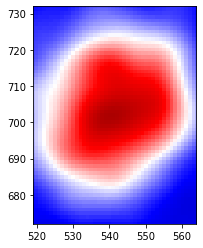

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import patches
plt.imshow(img)
plt.ylim(672,732)
plt.xlim(519,564)

(400.0, 800.0)

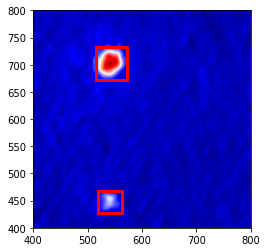

In [ ]:
fig,ax = plt.subplots()
ax.imshow(img)
for row in results[0]['rois']:
  x0 = row[1]
  y0 = row[0]
  width = row[3]-row[1]
  height = row[2]-row[0]

  ax.add_patch(patches.Rectangle((x0,y0),width, height, edgecolor = 'r', linewidth=3, facecolor = 'None'))
ax.set_xlim(400,800)
ax.set_ylim(400,800)